<a href="https://colab.research.google.com/github/Aditya-Raj-Kaushik/FlyDubai/blob/main/Cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 CLUSTER PATTERNS:

        Arrival_Delay        Departure_Delay         \
                 mean    std            mean    std   
Cluster                                               
0                2.65  34.08           -0.72  34.21   
1               -4.10  33.98            1.01  34.23   
2                1.50  34.11            0.95  34.20   
3               -1.30  34.22           -1.11  34.18   

        Passenger Mishandling Probability (%)         \
                                         mean    std   
Cluster                                                
0                                       91.82  10.40   
1                                       51.77  16.48   
2                                       83.50  17.85   
3                                       76.25  20.82   

        Passenger Class of Travel Weather Conditions Gate Congestion Level  \
                         <lambda>           <lambda>              <lambda>   
Cluster                                     

<ipython-input-15-781cab05f3c1>:109: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


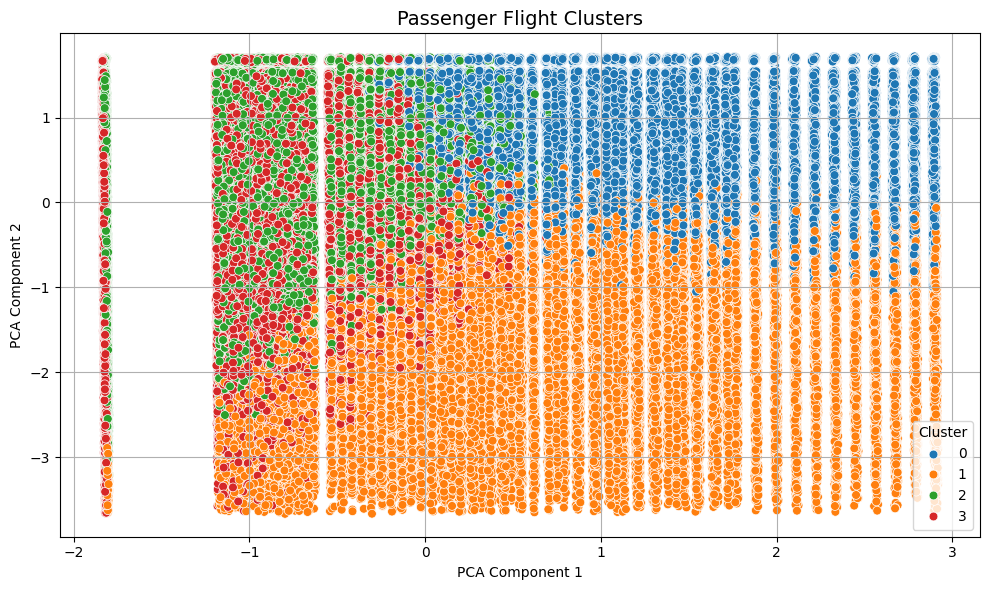

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/passenger_mishandling_large_dataset.csv")


datetime_cols = ['STA (Standard Time of Arrival)', 'ETA (Estimated Time of Arrival)',
                 'ATA (Actual Time of Arrival)', 'ETD (Estimated Time of Departure)',
                 'ATD (Actual Time of Departure)']

for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df.dropna(subset=datetime_cols, inplace=True)

df['Arrival_Delay'] = (df['ATA (Actual Time of Arrival)'] - df['ETA (Estimated Time of Arrival)']).dt.total_seconds() / 60
df['Departure_Delay'] = (df['ATD (Actual Time of Departure)'] - df['ETD (Estimated Time of Departure)']).dt.total_seconds() / 60

df = df[(df['Arrival_Delay'].between(-600, 600)) & (df['Departure_Delay'].between(-600, 600))]

features = [
    'Passenger Connecting Time (mins)',
    'Number of Checked-in Passengers',
    'Number of Checked-in Infant Passengers',
    'Passenger Class of Travel',
    'Reservation Status',
    'Onward Connection Indicator',
    'Number of Baggage Items',
    'Weight of Baggage (kg)',
    'Baggage Status',
    'Baggage Not Loaded Indicator',
    'Baggage Not Seen for Loading Indicator',
    'Interline Flight Indicator',
    'Airport Terminal Congestion Level',
    'Gate Congestion Level',
    'Weather Conditions',
    'Arrival_Delay',
    'Departure_Delay',
    'Passenger Mishandling Probability (%)'
]

df = df[features].dropna()


numerical_features = [
    'Passenger Connecting Time (mins)',
    'Number of Checked-in Passengers',
    'Number of Checked-in Infant Passengers',
    'Number of Baggage Items',
    'Weight of Baggage (kg)',
    'Arrival_Delay',
    'Departure_Delay',
    'Passenger Mishandling Probability (%)'
]

categorical_features = [
    'Passenger Class of Travel',
    'Reservation Status',
    'Onward Connection Indicator',
    'Baggage Status',
    'Baggage Not Loaded Indicator',
    'Baggage Not Seen for Loading Indicator',
    'Interline Flight Indicator',
    'Airport Terminal Congestion Level',
    'Gate Congestion Level',
    'Weather Conditions'
]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

X = preprocessor.fit_transform(df)

pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X)

kmeans = MiniBatchKMeans(n_clusters=4, batch_size=1000, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_pca)

summary = df.groupby('Cluster').agg({
    'Arrival_Delay': ['mean', 'std'],
    'Departure_Delay': ['mean', 'std'],
    'Passenger Mishandling Probability (%)': ['mean', 'std'],
    'Passenger Class of Travel': lambda x: x.value_counts().index[0],
    'Weather Conditions': lambda x: x.value_counts().index[0],
    'Gate Congestion Level': lambda x: x.value_counts().index[0],
    'Baggage Status': lambda x: x.value_counts().index[0],
}).round(2)

print("\n CLUSTER PATTERNS:\n")
print(summary)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='tab10', s=40)
plt.title("Passenger Flight Clusters", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [16]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split

# Use the same X (preprocessed data) and df['Cluster'] from previous step
X_train, X_test, y_train, y_test = train_test_split(X, df['Cluster'], test_size=0.2, random_state=42)

# Simple interpretable tree
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train, y_train)

# Show decision rules
feature_names = preprocessor.get_feature_names_out()
tree_rules = export_text(tree, feature_names=list(feature_names))
print("\n Decision Tree Rules Explaining Cluster Assignments:\n")
print(tree_rules)



 Decision Tree Rules Explaining Cluster Assignments:

|--- num__Number of Baggage Items <= 0.35
|   |--- num__Passenger Connecting Time (mins) <= 0.02
|   |   |--- num__Weight of Baggage (kg) <= -0.00
|   |   |   |--- num__Passenger Mishandling Probability (%) <= -1.22
|   |   |   |   |--- class: 2
|   |   |   |--- num__Passenger Mishandling Probability (%) >  -1.22
|   |   |   |   |--- class: 2
|   |   |--- num__Weight of Baggage (kg) >  -0.00
|   |   |   |--- num__Passenger Mishandling Probability (%) <= -0.08
|   |   |   |   |--- class: 1
|   |   |   |--- num__Passenger Mishandling Probability (%) >  -0.08
|   |   |   |   |--- class: 2
|   |--- num__Passenger Connecting Time (mins) >  0.02
|   |   |--- num__Weight of Baggage (kg) <= -0.08
|   |   |   |--- num__Passenger Connecting Time (mins) <= 0.32
|   |   |   |   |--- class: 3
|   |   |   |--- num__Passenger Connecting Time (mins) >  0.32
|   |   |   |   |--- class: 3
|   |   |--- num__Weight of Baggage (kg) >  -0.08
|   |   |  

In [17]:
importances = tree.feature_importances_
important_features = sorted(zip(importances, feature_names), reverse=True)[:10]

print("\n Top 10 Influential Features:")
for score, name in important_features:
    print(f"{name}: {score:.4f}")



 Top 10 Influential Features:
num__Passenger Connecting Time (mins): 0.3142
num__Passenger Mishandling Probability (%): 0.3014
num__Number of Baggage Items: 0.2904
num__Weight of Baggage (kg): 0.0940
num__Number of Checked-in Passengers: 0.0000
num__Number of Checked-in Infant Passengers: 0.0000
num__Departure_Delay: 0.0000
num__Arrival_Delay: 0.0000
cat__Weather Conditions_Stormy: 0.0000
cat__Weather Conditions_Rainy: 0.0000
